In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()
sns.set_context("talk")
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind")
date_form = DateFormatter("%Y-%m-%d\n%H:%M")


In [2]:
sml_lt_df = pd.read_csv("Data/SML LT 2001.csv")
sml_lt_df['Date_UTC'] = pd.to_datetime(sml_lt_df['Date_UTC'])

sme_df = pd.read_csv("Data/SME 2001.csv")
sme_df['Date_UTC'] = pd.to_datetime(sme_df['Date_UTC'])

ng2011df = pd.read_csv("Data/substorms-newell-20000101_000000_to_20070101_000000.csv")
ng2011df['Date_UTC'] = pd.to_datetime(ng2011df['Date_UTC'])
ng2011_2001 = ng2011df[ng2011df['Date_UTC'].dt.year == 2001].reset_index(drop=True)

In [3]:
no_sectors = 7
MLT_sectors = np.concatenate([np.arange((24-np.floor(no_sectors/2)), 24), np.arange(0, no_sectors/2)]).ravel().astype(int)
allsec = [i for i in np.arange(0,24)]
allsec_names = [f'SMLr{i:02d}' for i in allsec]
MLT_sec_names =  [f'SMLr{i:02d}' for i in MLT_sectors]
SMLnightdf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLnight':sml_lt_df[MLT_sec_names].min(axis=1)})
SMLalldf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLall':sml_lt_df[allsec_names].min(axis=1)})

In [4]:
smlnight_scaled =((SMLnightdf['SMLnight'] - SMLnightdf['SMLnight'].mean())/SMLnightdf['SMLnight'].std()).to_numpy()
sml_scaled = ((sme_df['SML'] - sme_df['SML'].mean())/sme_df['SML'].std()).to_numpy()


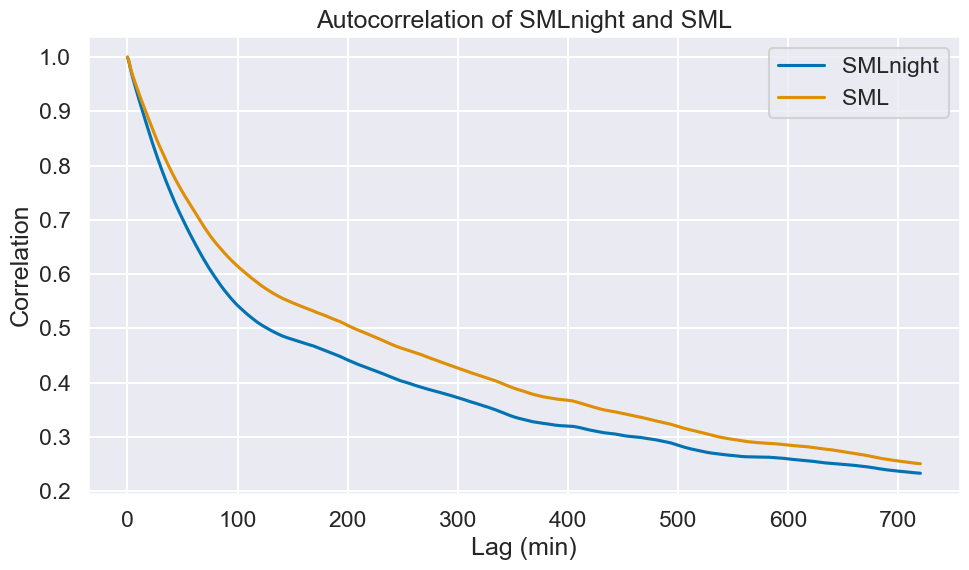

In [5]:
sml5_acorr = sm.tsa.stattools.acf(smlnight_scaled, nlags=12*60)
sml_acorr = sm.tsa.stattools.acf(sml_scaled, nlags=12*60)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_acorr, label='SMLnight')
ax.plot(sml_acorr, label='SML')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Autocorrelation of SMLnight and SML')

plt.tight_layout(pad=1)

In [8]:
onsettimes = []
onsetsectors = []
minimas = []
minimatimes = []
sml_array = sml_lt_df[MLT_sec_names].values

untilnext = 0
for index, __ in SMLnightdf[:-30].iterrows():
    onsettime = SMLnightdf['Date_UTC'][index]
    onsetsml = SMLnightdf['SMLnight'][index]
    onsetsector = np.where(sml_array[index]==onsetsml)[0]
    if untilnext > 1:
        untilnext -= 1
        continue
    if (SMLnightdf['SMLnight'][index + 1] - onsetsml) < -15:
        if (SMLnightdf['SMLnight'][index + 2] - onsetsml) < -30:
            if (SMLnightdf['SMLnight'][index + 3] - onsetsml) < -45:
                window = SMLnightdf['SMLnight'][index + 4:index + 30]
                if np.sum(window)/26 - onsetsml < -100:
                    onsettimes.append(onsettime)
                    onsetsectors.append(', '.join([str(element) for element in MLT_sectors[onsetsector]]))
                    minimas.append(window.min())
                    minimatimes.append(SMLnightdf['Date_UTC'][window.idxmin()])
                    untilnext = 20
    else:
        untilnext -= 1
        
ng2011_night = pd.DataFrame({'Date_UTC':onsettimes, 'MLT_onset':onsetsectors, 'SML_Minima': minimas, 'Date_UTC_minima': minimatimes})

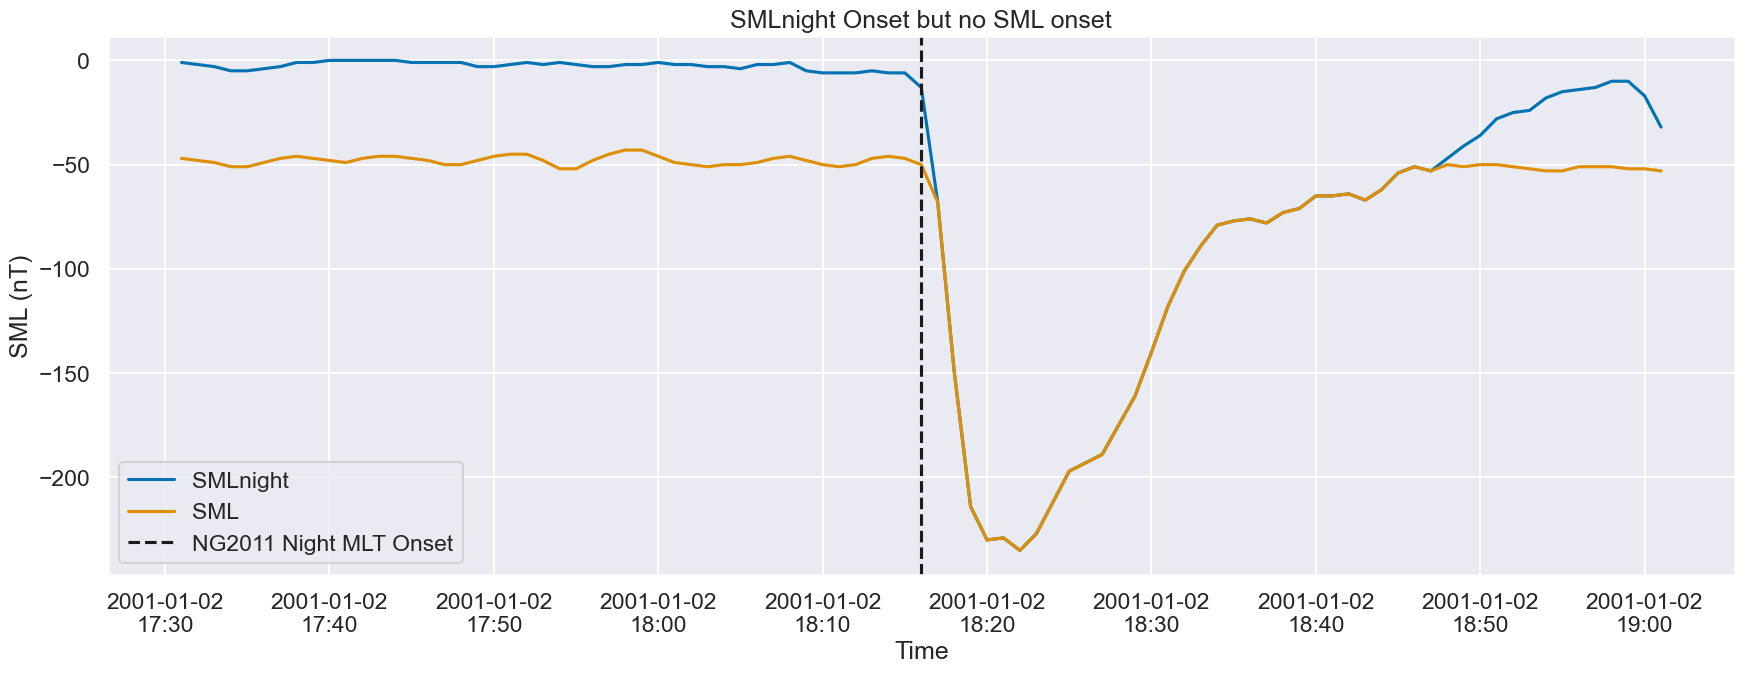

In [10]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_night['Date_UTC'], ng2011_2001['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k',ls='--',label='NG2011 Night MLT Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SMLnight Onset but no SML onset')
ax.xaxis.set_major_formatter(date_form)

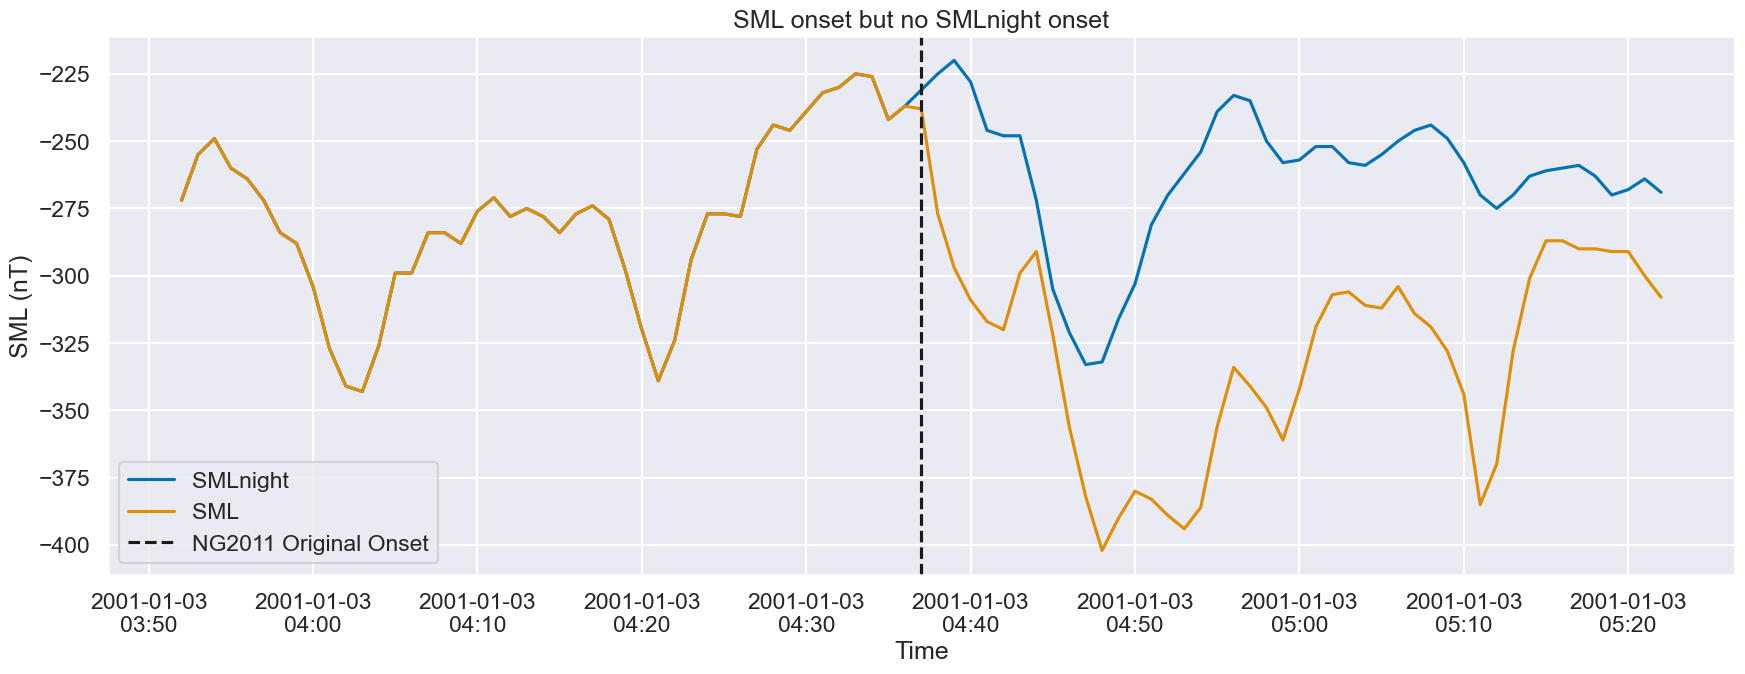

In [13]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_2001['Date_UTC'], ng2011_night['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k', ls='--', label='NG2011 Original Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SML onset but no SMLnight onset')
ax.xaxis.set_major_formatter(date_form)